In [ ]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [ ]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
  messages: Annotated[list, add_messages]
  
  
graph_builder = StateGraph(State)

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

llm_with_tools = llm.bind_tools(tools=tools)

In [7]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [8]:
graph_builder.add_node("chatbot", chatbot)

# Tool Node

In [9]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    # when node called get last message
    # for each tool called in message get it by name, invoke passing it's args
    # finally write to the state passing the outputs to messages as "ToolMessage" type
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [10]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Tool route

This route_tool function, basically does what `tools_condition` does
```python
from from langgraph.prebuilt import ToolNode, tools_condition
```

In [13]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [14]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)

In [15]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

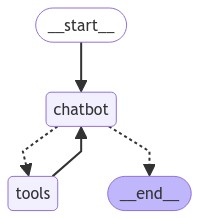

In [16]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.bbc.com/news/world-latin-america-64138739", "content": "Beta Terms By using the Beta Site, you agree that such use is at your own risk and you know that the Beta Site may include known or unknown bugs or errors, that we have no obligation to make this Beta Site available with or without charge for any period of time, nor to make it available at all, and that nothing in these Beta Terms or your use of the Beta Site creates any employment relationship between you and us. First rioter tried for Brazil capital unrest gets 17 years\nBrazil tightens gun control amid surge in ownership\nAmazon deforestation down by a third in 2023 - Brazil\nFifa investigating Brazil-Argentina disorder\nFifa opens disciplinary proceedings after fighting delayed the start of a World Cup qualifying match between Brazil and Argentina.\n Shortly after being sworn in, Lula sought to instil a sense of hope in the people of Brazil and promised to \"rebuild the nation and m